# QCoDeS Drivers for Keysight AWG (M3202A) and Digitizer (M3102A) Demos
---
### Author: Noah Tajwar
### Date: 2021-05-27
---

## Background

### Instruments

We currently have a Keysight PXIe Chassis (M9019A) connected to the lab computer (ece-cdw-js01). The following modules are installed in the chassis:
* \[**Slot 1**\] [M9024A: PXIe High Performance System Module](https://www.keysight.com/ca/en/product/M9024A/pxie-high-perf-system-module-connectivity-expansion-dual-port.html)
  * This module connects to the PC which acts as a controller
  * There is an alternative setup where you can put an embedded controller in slot 1 and then you don't need a connection to a PC (we don't have that)
* \[**Slot 3**\] [M3102A: PXIe Digitizer](https://www.keysight.com/ca/en/product/M3102A/pxie-digitizer-500-msa-s-14-bit-200-mhz.html)
  * 500 MSa/s
  * 14-bit
  * 200 MHz
* \[**Slot 4**\] [M3202A: PXIe Arbitrary Waveform Generator (AWG)](https://www.keysight.com/ca/en/product/M3202A/pxie-arbitrary-waveform-generator-1-gsa-s-14-bit-400-mhz.html)
  * 1 GS/s
  * 14-bit
  * 400 MHz

### [QCoDeS](https://qcodes.github.io/)

QCoDeS does not currently have drivers for these Keysight modules in their main repository. However, the repository of third-party contributed drivers ([Qcodes_contrib_drivers](https://github.com/QCoDeS/Qcodes_contrib_drivers)) does have some driver support for these modules:
* M3202A (AWG): Fully functional driver
* M3102A (Digitizer): There is a base-class driver (`SD_DIG`) that seems to partially work but some things are implemented strangely

I've forked the Qcodes_contrib_drivers repo [here](https://github.com/noaht11/Qcodes_contrib_drivers) and fixed `SD_DIG` as well as added a specific driver for the `M3102A` (more on that at the bottom of the notebook). After setting up QCoDeS, install the updated Qcodes_contrib_drivers package:
```
git clone git@github.com:noaht11/Qcodes_contrib_drivers.git
pip install ./Qcodes_contrib_drivers
```

### [Keysight SD1 3.x](https://www.keysight.com/ca/en/lib/software-detail/instrument-firmware-software/sd1-3x-software-3120392.html)

SD1 is the name of the software library provided by Keysight for controlling and interfacing with their PXIe modules (we are using version 3.x). This includes a Python API which is used by the Qcodes_contrib drivers.

There are User's Guides for each of the PXIe modules that have all the necessary information to use the Python API:
* [M3202A (AWG) User's Guide](http://literature.cdn.keysight.com/litweb/pdf/M3XXX-90003.pdf)
* [M3102A (Digitizer) User's Guide](http://literature.cdn.keysight.com/litweb/pdf/M3XXX-90004.pdf)

---

The rest of this notebook includes some examples of how to use the Qcodes drivers to operate the AWG and Digitizer

---

## Initial Setup (run before anything else)

Load all the Python modules for using the Qcodes drivers (and any other dependencies).

NOTES:
* The Keysight SD1 Python API may need to be added to the path before it can be loaded. This is done automatically by the script (assuming the API is installed in `C:\Program Files (x86)\Keysight\SD1\Libraries\Python`)
* Make sure you have installed the forked Qcodes_contrib_drivers package (see above) otherwise `Keysight_M3102A` will fail to load
* This assumes the Digitizer is in slot 3 and the AWG is in slot 4, update as required (see the comment in the code)

In [1]:
import logging

import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt

try:
    import keysightSD1
except:
    import sys
    # Update this path if you have the SD1 library installed somewhere else
    sys.path.append(r"C:\Program Files (x86)\Keysight\SD1\Libraries\Python")
    import keysightSD1
    
import qcodes
from qcodes_contrib_drivers.drivers.Keysight.M3202A import M3202A # AWG
from qcodes_contrib_drivers.drivers.Keysight.Keysight_M3102A import Keysight_M3102A # Digitizer

import qcodes.logger as logger
from qcodes.logger import start_all_logging

from waveforms import create_sine, create_gaussian, queue_oneshot, trigger_fall
from digitizer import setup_dig_pxi

start_all_logging()
# logger.get_file_handler().setLevel(logging.DEBUG)

# try to close station from previous run.
try:
    station.close_all_registered_instruments()
except: pass

# setup station (update the slot numbers if necessary)
awg = M3202A("AWG", chassis = 1, slot = 4)
dig = Keysight_M3102A("DIG", chassis = 1, slot = 3)

station = qcodes.Station()
station.add_component(awg)
station.add_component(dig)

# Some global constants for reference later
AWG_SAMPLE_RATE_MSPS = 1000 # 1 GS/s
DIG_SAMPLE_RATE_MSPS = 500 # 500 MS/s

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\noah\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


2021-05-26 18:05:46,196 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 215 ¦ [AWG(M3202A)] Snapshot: Could not update parameter: status
2021-05-26 18:05:46,208 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 215 ¦ [DIG(Keysight_M3102A)] Snapshot: Could not update parameter: status


Qcodes Logfile : C:\Users\noah\.qcodes\logs\210526-11576-qcodes.log


## AWG-Only Demos

Each of the following demos can be run independently in any order. These demos generate single-shot waveforms on the AWG channel 1.
These waveforms can be captured on an oscilloscope in single-shot trigger mode.

### 1. Sine Wave (Auto-trigger)

The cell below generates 8 periods of a sine wave with frequency 2 MHz (period 500 ns). The automatic trigger is used so the waveform is output immediately.

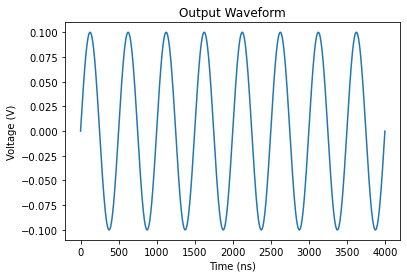

In [2]:
sine_wave = 0.1 * create_sine(500, 8, AWG_SAMPLE_RATE_MSPS)
plt.plot(sine_wave)
plt.title("Output Waveform")
plt.xlabel("Time (ns)")
plt.ylabel("Voltage (V)")

queue_oneshot(awg, 1, sine_wave, AWG_SAMPLE_RATE_MSPS)

### 2. Gaussian Pulse (Auto-trigger)

The cell below generates a Gaussian pulse with a FWHM (full-width-half-max) of 100 ns. The automatic trigger is used so the waveform is output immediately.

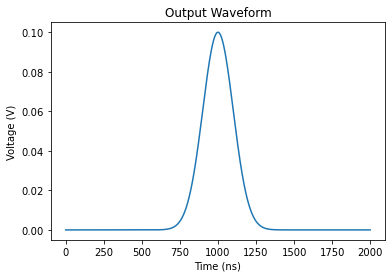

In [3]:
gauss_wave = create_gaussian(0.1, 0, 100, 2000, AWG_SAMPLE_RATE_MSPS)
plt.plot(gauss_wave)
plt.title("Output Waveform")
plt.xlabel("Time (ns)")
plt.ylabel("Voltage (V)")

queue_oneshot(awg, 1, gauss_wave, AWG_SAMPLE_RATE_MSPS)

### 3. Gaussian Pulse (Ext-trigger)

The cell below generates the same Gaussian pulse as the previous demo. The external trigger (PXI trigger line 1) is used so the waveform is output only when we call `trigger_fall`.

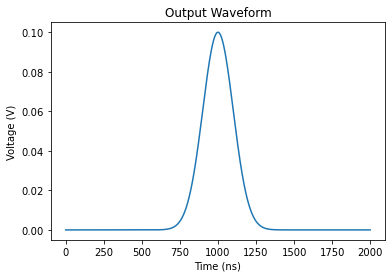

In [4]:
gauss_wave = create_gaussian(0.1, 0, 100, 2000, AWG_SAMPLE_RATE_MSPS)
plt.plot(gauss_wave)
plt.title("Output Waveform")
plt.xlabel("Time (ns)")
plt.ylabel("Voltage (V)")

queue_oneshot(awg, 1, gauss_wave, AWG_SAMPLE_RATE_MSPS, trigger=keysightSD1.SD_TriggerModes.EXTTRIG, trigger_pxi_line=1)
trigger_fall(awg, trigger_pxi_line=1)

## AWG + Digitizer Demos

Each of the following demos can be run independently in any order. These demos generate single-shot waveforms on the AWG channel 4 and read the digitizer input on channel 1, so you should connect these two ports via a coax cable. The two modules have their triggers synchronized by the PXI chassis trigger line 1.

### 1. Gaussian Pulse

In [15]:
# Create waveform
duration_ns = 2000
amplitude = 0.1

gauss_wave = create_gaussian(amplitude, 0, 200, duration_ns, AWG_SAMPLE_RATE_MSPS)
plt.plot(gauss_wave, label="Output Waveform")

# Queue waveform on channel 1 and 4 on the AWG
queue_oneshot(awg, 1, gauss_wave, AWG_SAMPLE_RATE_MSPS, trigger=keysightSD1.SD_TriggerModes.EXTTRIG, trigger_pxi_line=1)
queue_oneshot(awg, 4, gauss_wave, AWG_SAMPLE_RATE_MSPS, trigger=keysightSD1.SD_TriggerModes.EXTTRIG, trigger_pxi_line=1)

# Setup and start digitizer
full_scale = amplitude
setup_dig_pxi(dig, 1, duration_ns, full_scale, trigger_pxi_line=1)

# Trigger both
trigger_fall(awg, trigger_pxi_line=1)

# Capture and plot measured result
data = dig.daq_read(1)
time_domain_ns = np.arange(len(data)) * (1000 / 500)
data = data / (2**15) * full_scale
plt.plot(time_domain_ns, data, label="Measured Waveform")

# Tidy up plot
plt.xlabel("Time (ns)")
plt.ylabel("Voltage (V)")
plt.legend()